![nawa](https://nawa.gov.pl/images/rozszerzenia/szablony/siteb3/logo-komputer.png)

**WORKSHOP ON HYPERGRAPH MODELLING** @ 17th Workshop on Algorithms and Models for the Web Graph

_Carmine Spagnuolo,_ Ph.D.

## Modeling epidemic diffution via Hypergraphs

In epidemiology science, the importance to explore innovative modeling tools for acutely analyzing epidemic diffusion is turning into
a big challenge considering the myriad of real-world aspects to capture. Typically, equation-based models, such as SIS and SIR, are used
to study the propagation of diseases over a population. Improved
approaches also include human-mobility patterns as network information to describe contacts among individuals. However, there still
is the need to incorporate in these models information about different types of contagion, geographical information, humans habits,
and environmental properties. In this paper, we propose a novel approach that takes into account: 1. direct and indirect epidemic contagion pathways to explore the dynamics of the epidemic, 2. the times
of possible contagions, and 3. human-mobility patterns. We combine these three features exploiting time-varying hypergraphs, and
we embed this model into a design-methodology for agent-based
models (ABMs), able to improve the correctness in the epidemic
estimations of classical contact-network approaches. We further
describe a diffusion algorithm suitable for our design-methodology
and adaptable to the peculiarities of any disease spreading policies
and/or models. Finally, we tested our methodology by developing
an ABM, realizing the SIS epidemic compartmental model, for simulating an epidemic propagation over a population of individuals.
We experimented the model using real user-mobility data from the
location-based social network Foursquare, and we demonstrated the
high-impact of temporal direct and indirect contagion pathways.

For more detail about this epidemic model please refer to the following article. 

A. Antelmi, G. Cordasco, V. Scarano, C. Spagnuolo
_A Design-Methodology for Epidemic Dynamics via
Time-Varying Hypergraphs_. In Proc. of the 19th International Conference on Autonomous Agents
and Multiagent Systems (AAMAS 2020), Auckland, New Zealand, May 9–13,
2020, IFAAMAS. [Download](http://www.ifaamas.org/Proceedings/aamas2020/pdfs/p61.pdf).

In [1]:
using Pkg
pkg"add SimpleHypergraphs Dates DataFrames JSONTables JSON3 CSV Statistics PyPlot"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [2]:
using SimpleHypergraphs
using Dates
using DataFrames
using JSONTables
using JSON3
using CSV
using Statistics
using PyPlot

 Simulate a Susceptible-Infected-Susceptible diffusion model exploiting a
 Time-Varying Hypergraph. An immunization strategy may be applied either
 on vertices (i.e. people) and hyperedges (i.e. locations).

In [3]:
"""
    simulate(
            df::DataFrame,
            intervals::Dict{Int, Pair{DateTime, DateTime}},
            user2vertex::Dict{String, Int},
            loc2he::Dict{String, Int},
            δ::Dates.Millisecond;
            Δ::Union{Int,TimePeriod,Nothing} = nothing,
            vstatus::Union{Array{Int, 1}, Nothing} = nothing,
            per_infected::Float64 = 0.2,
            c::Union{Int, Nothing} = 5,
            βd::Float64 = 0.2,
            βₑ::Float64 = 0.06,
            βᵢ::Float64 = 0.1,
            γₑ::Float64 = 0.06,
            γₐ::Float64 = 0.1,
            niter::Int = 1,
            output_path::Union{AbstractString, Nothing} = nothing
    )

 **Arguments**
 - `df`, DataFrame containing check-in data;
 - `intervals`, time intervals within which an indirect contact may happen;
 - `user2vertex`, mapping from agent ids to vertex ids;
 - `loc2he`, mapping from location ids to hyperedge ids;
 - `δ`, time within which a direct contact may happen (expressed in milliseconds);
 - `Δ`, time within which an indirect contact may happen (just for logging purposes);
 - `vstatus`, initial status (susceptible or infected) for each node. If it not
 given as input, it will be initialized in the simulation;
 - `per_infected`, percetage of initial infected agents;
 - `c`, factor bounding the probability to become infected when the number of
 contact increases;
 - `βd`, probability of becoming infected with a direct contact;
 - `βₑ`, probability that a location is infected by an agent;
 - `βᵢ`, probability of becoming infected with an indirect contact;
 - `γₑ`, probability that a location spontaneously recovers;
 - `γₐ`, probability that an agent spontaneously recovers;
 - `niter`, number of iteration the simulation is repeated.

"""
function simulate(
        df::DataFrame,
        intervals::Dict{Int, Pair{DateTime, DateTime}},
        user2vertex::Dict{String, Int},
        loc2he::Dict{String, Int},
        δ::Dates.Millisecond;
        Δ::Union{Int,TimePeriod,Nothing} = nothing,
        vstatus::Union{Array{Int, 1}, Nothing} = nothing,
        per_infected::Float64 = 0.2,
        c::Union{Int, Nothing} = 5,
        βd::Float64 = 0.2,
        βₑ::Float64 = 0.06,
        βᵢ::Float64 = 0.1,
        γₑ::Float64 = 0.06,
        γₐ::Float64 = 0.1,
        niter::Int = 1
)

    # iter -> percentage of infected agents per simulation step
    to_return = Dict{Int, Array{Float64, 1}}()

    # evaluation of an initial vector of infected agents
    # if it is not given as input
    if isnothing(vstatus)
        vstatus = fill(1, length(user2vertex))
        vrand = rand(Float64, length(user2vertex))
        for i=1:length(user2vertex)
            if per_infected  <= vrand[i]
                vstatus[i] = 0
            end
        end
    end

    # for randomization purposes
    for iter=1:niter
        println("Iter $(iter)")

        h = nothing
        added, moved = 0, 0

        # percentage of infected per simulation step
        per_infected_sim = Array{Float64, 1}()

        # store which agents are present in the given timeframe
        agentsepoc = zeros(Int, length(user2vertex))

        # Initialize the status vector of the nodes
        _vstatus = copy(vstatus)
        # Initially, all location are safe
        hestatus = zeros(Int, length(loc2he))

        # Storing the new status of each vertex and hyperedge
        vnextstatus = copy(vstatus)
        henextstatus = copy(hestatus)

        push!(per_infected_sim, sum(_vstatus) / length(_vstatus))

        ################
        # SIMULATION
        ################
        for t=1:length(intervals)
            h, added, moved = generatehg!(
                                h,
                                df,
                                get(intervals, t, 0).first,
                                get(intervals, t, 0).second,
                                user2vertex,
                                loc2he,
                                agentsepoc,
                                t
                            )

            isnothing(h) && continue

            ########################
            # DIFFUSION ALGORITHM
            ########################

            #
            # PHASE 1 - Agent-to-Environment
            #
            for he=1:nhe(h)

                # If the location has at least two agents
                # and it is not infected, it may become contamined.
                if length(getvertices(h, he)) > 1 && hestatus[he] == 0
                    i = infected(h, he, _vstatus)
                    if rand() <  1 - ℯ ^ - (βₑ * f(i, c))
                        # the location is contaminated
                        henextstatus[he] = 1
                    end
                elseif rand() <  1 - ℯ ^ - γₑ
                    # the location has been sanitized
                    henextstatus[he] = 0
                end
            end


            #
            # PHASE 2 - Agent-to-Agent
            #
            for v=1:nhv(h)

                # if the agent is present in the current timeframe
                if agentsepoc[v] == 1
                    i = 0
                    for he in gethyperedges(h, v)

                        for u in getvertices(h, he.first)
                            if v != u.first
                                # if u and v have been together in the same place
                                # in a time interval less than δ
                                # then it counts ad a direct contact
                                if abs(h[v, he.first] - h[u.first, he.first]) <= δ.value
                                    if _vstatus[v] == 0
                                        i += _vstatus[u.first]
                                    end
                                end
                            end
                        end
                    end
                    # a agent becomes infected according to
                    # the following probbaility
                    if _vstatus[v] == 0 && rand() < 1 - ℯ ^ - (βd * i)
                        vnextstatus[v] = 1
                    end
                end
            end


            #
            # PHASE 3 - Environment-to-Agent
            #
            for v=1:nhv(h)

                # if the agent is present in the current timeframe
                if agentsepoc[v] == 1

                    # if the agent is healthy and
                    # it is not immunized,
                    # it may become infected
                    if _vstatus[v] == 0
                        i = 0

                        for he in gethyperedges(h, v)
                            if length(getvertices(h, he.first)) > 1
                                i += hestatus[he.first]

                            end
                        end

                        if rand() < 1 - ℯ^-(βᵢ * f(i, c))
                            vnextstatus[v] = 1
                        end

                    elseif rand() < 1 - ℯ ^ - γₐ
                        # the agent spontaneously returns healthy
                        vnextstatus[v] = 0
                    end
                end
            end

            _vstatus = copy(vnextstatus)
            hestatus = copy(henextstatus)

            push!(per_infected_sim, sum(_vstatus) / length(_vstatus))

        end

        push!(to_return, iter=>per_infected_sim)

    end
    

    to_return
end
;

In [4]:
"""
    infected(h, he, vstatus, istatus)

Count the number of infected nodes within an hyperedge.
"""
function infected(
    h::Hypergraph, 
    he::Int, 
    vstatus::Array{Int, 1},
)
    vertices = getvertices(h, he)
    sum = 0
    for v in vertices
        sum += vstatus[v.first]
    end
    sum
end
;

In [5]:
"""
    f(num_infected, c)

Non-linear function used to bound the infection pressure
for large values of 𝑛.
"""
function f(num_infected::Int, c::Int)
    num_infected > c ? c : num_infected
end
;

## Utility functions

In [6]:
"""
    generate_model_data()

Load a dataframe from a file `fname` with columns `columns`, containing checkin-data.

Note: the name of the columns have to be Symbol.

Return:
- a `dataframe` containing all the checkins that will be used for the simulation;
- a `dict` of intervals within which an indirect contact may occur:
    - at each interval `i` corresponds a pair of dates delimiting that interval
    - `i` => (date₁, date₂)
- a `dict` maping each user to the corresponding node id in the hypergraph
- a `dict` maping each location to the corresponding hyperedge id in the hypergraph

### Arguments
- `userid` : column corresponding to user ids (and to vertices);
- `venueid` : column corresponding to venue ids (and to hyperedges);
- `timestamp` : column corresponding to the checkin timestamps (and to weights);
- `dateformat`: the format of the timestamp of the checkin;
- `Δ`: time within which an indirect contact may happen;
- `δ`: time within which a direct contact may happen;
- `mindate`: if set, a checkin is considered only if it happend after `mindate`;
- `maxdate`: if set, a checkin is considered only if it happend before `maxdate`.
"""
function generate_model_data(
    fname::AbstractString,
    columns::AbstractVector{Symbol},
    userid::Symbol,
    venueid::Symbol,
    timestamp::Symbol,
    dateformat::AbstractString;
    Δ::Millisecond = Dates.Millisecond(14400000),
    δ::Millisecond = Dates.Millisecond(1000),
    mindate::Union{DateTime,Nothing} = nothing,
    maxdate::Union{DateTime,Nothing} = nothing
)

    df = CSV.read(
        fname;
        copycols = true,
        header = columns,
        dateformat = dateformat
    )
    

    # remove all rows without a timestamp
    df = dropmissing(df, timestamp)
    df = dropmissing(df)

    # filter out all the rows not in the
    # timeframe to consider
    df = filter(
        r-> (isnothing(mindate) || r[timestamp] >= mindate) &&
            (isnothing(maxdate) || r[timestamp] <= maxdate),
            df
    )

    sort!(df, [timestamp])

    # vertices
    users = unique(df, userid)
    numusers = nrow(users)

    # hyperedges - upper buond
    places = unique(df, venueid)
    numplaces = nrow(places)

    # time slots
    mintime = minimum(df[!, timestamp])
    maxtime = maximum(df[!, timestamp])

    nintervals = ceil(Int, (maxtime - mintime) / Δ)
    intervals = Dict{Int, Pair{DateTime, DateTime}}()

    # build timeframes
    for i = 1:nintervals
        offset =
            mintime + Δ + δ > maxtime ? maxtime + Dates.Millisecond(1) : mintime + Δ + δ

        get!(
            intervals,
            i,
            Pair{DateTime,DateTime}(
                convert(Dates.DateTime, (mintime - δ)), convert(Dates.DateTime, (offset))
            )
        )

        mintime = offset - δ
    end

    # mapping user -> node
    user2vertex = Dict{String, Int}()
    index = 1

    # add vertices
    for user in eachrow(users)
        uid = string(user[userid])
        if !haskey(user2vertex, uid)
            push!(user2vertex, uid => index)
            index += 1
        end
    end

    # mapping place -> he
    loc2he = Dict{String, Int}()
    index = 1

    # add he
    for place in eachrow(places)
        placeid = string(place[venueid])
        if !haskey(loc2he, placeid)
            push!(loc2he, placeid => index)
            index += 1
        end
    end

    rename!(df, [userid => :userid, venueid => :venueid, timestamp => :timestamp])

    df, intervals, user2vertex, loc2he
end
;

In [7]:
"""
    generatehg(
        h::Hypergraph,
        df::DataFrame,
        mindate::DateTime,
        maxdate::DateTime,
        user2vertex::Dict{String, Int},
        loc2he::Dict{String, Int},
        usersepoc::Vector{Int},
        t::Int;
        all::Bool = true
    )

Populate a hypergraph `h` with checkin data from the dataframe `df`
happening within `mindate` and `maxdate`.

At the first step of the simulation, `h` is `nothing`. In this case,
it initializes a new hypergraph `h`, where its vertices correspond to users in `user2vertex`
and its hyperedges to locations in `loc2he`. For each user, the timestamp of the last checkin
he/she did in a given location is stored.

In the following simulation steps, `h` is modified according to the new checkin data.
Also in this case, the timestamp of the last checkin a user did in a given location is stored.

`usersepoc` containes information about whether a given user was
already present in the simulation. Based on this vector, the number of
newcoming users or users who just moved in another location is evaluated.

`t` is the current simulation step. In combination with `all`, it can be used
for debugging purposes.
"""
function generatehg!(
    h::Union{Hypergraph, Nothing},
    df::DataFrame,
    mindate::DateTime,
    maxdate::DateTime,
    user2vertex::Dict{String, Int},
    loc2he::Dict{String, Int},
    usersepoc::Vector{Int},
    t::Int;
    all::Bool = true
)

    added, moved = 0, 0

    # select only the current timeframe
    currdf = filter(r->((r.timestamp >= mindate) && (r.timestamp < maxdate)), df)

    # initialize hg
    if isnothing(h)
        # first step of the simulation
        # initialize the hypergraph from scratch
        h = inithg(currdf, user2vertex, loc2he)
    else
        # clean the timestamp stored within the hypergraph
        # it stores only the last checkin for each user
        for v = 1:nhv(h)
            max, id = 0, 0
            for he in gethyperedges(h, v)
                if getindex(h, v, he.first) > max
                    max = getindex(h, v, he.first)
                    id = he.first
                end
                setindex!(h, nothing, v, he.first)
            end
            if id != 0
                setindex!(h, max, v, id)
            end
        end
    end

    # Repopulate the hypergraph with checkins
    # from the new timeframe
    for checkin in eachrow(currdf)
        # if the user was not in any other venue, i.e. an hyperedge,
        # then it is a new coming node
        usersepoc[get(user2vertex, string(checkin.userid), -1)] == 0 ?
            usersepoc[get(user2vertex, string(checkin.userid), -1)] = 1 : moved += 1

        # if a user visits the same place in the same timeframe
        # only the timestamp of his/her last checkin is stored
        if t == 1 || all #just for debugging purposes
            setindex!(
                h,
                Dates.value(checkin.timestamp), # checkin to store
                get(user2vertex, string(checkin.userid), -1), # node id
                get(loc2he, string(checkin.venueid), -1) # hyperedge id
            )
        end
    end

    # number of newcoming users in the current timeframe
    added = nrow(currdf) - moved

    h, added, moved
end
;

In [8]:
"""
    inithg(
        df::DataFrame,
        user2vertex::Dict{String, Int},
        loc2he::Dict{String, Int}
    )

Initialize a hypergraph `h`, where its vertices correspond to users in `user2vertex`
and its hyperedges to locations in `loc2he`. For each user, the timestamp of the last checkin
he/she did in a given location is stored.

"""
function inithg(df::DataFrame, user2vertex::Dict{String, Int}, loc2he::Dict{String, Int})
    # Generate a hypergraph `h` with
    # `n` users and `m` locations
    # The ids of each user and each locations
    # are stored as metadata in `h`
    h = Hypergraph{Int, String, String}(length(keys(user2vertex)), length(keys(loc2he)))

    # Storing metadata
    for user in user2vertex
        set_vertex_meta!(h, user.first, user.second)
    end

    for place in loc2he
        set_hyperedge_meta!(h, place.first, place.second)
    end

    for checkin in eachrow(df)

        # this should never happen
        # the df is cleaned from missing data
        if get(loc2he, checkin.venueid, -1) == -1
            println(checkin.venueid)
        end

        # if a user visits the same place in the same timeframe
        # only the timestamp of his/her last checkin is stored
        setindex!(
            h,
            Dates.value(checkin.timestamp),  # checkin to store
            get(user2vertex, string(checkin.userid), -1), # node id
            get(loc2he, checkin.venueid, -1) # hyperedge id
        )
    end

    h
end
;

## Experiment

Here, we will evaluate the above epidemic process with a virtual agent society representing of Game of Thrones TV series characters.

First, we load:
* a hypergraph studying characters' co-occurences within scenes. Here, a hyperedge is a scene of a GoT episode, while the GoT characters are the nodes;
* the simulation parameters.

In [9]:
dataset = download(
    "https://raw.githubusercontent.com/spagnuolocarmine/spagnuolocarmine.github.io/master/assets/files/share/got_checkins.csv",
    "got_checkins.csv"
);

sim_params = download(
    "https://raw.githubusercontent.com/spagnuolocarmine/spagnuolocarmine.github.io/master/assets/files/share/got_spreading.json",
    "got_spreading.json"
);

In [10]:
header = [:character, :location, :timestamp]
dateformat = "yyyy-mm-ddTHH:MM:SS"
start_date = "2020-01-01T00:01:45"
end_date = "2020-01-07T23:57:21"
userid = "character"
venueid = "location"
UTCtime = "timestamp"
;

### Reading simulation params

In [11]:
jtable = jsontable(read(open(sim_params, "r")))
paramsdf = DataFrame(jtable)

# just a trick to group together
# all experiments to show in the same plot
test_data = Dict{String, Array{Any, 1}}()
for params in eachrow(paramsdf)
    push!(
        get!(test_data, params[:exp_id], Array{Any, 1}()),
        params
    )
end

paramsdf

,exp_id,exp,label,infected_percentage,c,Δ
,String,String,String,Float64,Int64,Int64
1,baseline,direct-indirect,Direct and Indirect,0.2,5,1
2,baseline,direct,Direct,0.2,5,1
3,baseline,indirect,Indirect,0.2,5,1


In [13]:
#########################
# Generating model data
########################

# The choice of the interval within which
# either an indirect (Δ) or direct (δ) contact
# may occur influences the data the
# simulation is run on.
# For this reason, it is necessary to store
# diffent information according to the
# values of both Δ and δ.
intervals = unique(paramsdf, [:Δ, :δ])[!, [:Δ, :δ]]
intervals_data = Dict{String, Dict{Symbol, Any}}()

for i in eachrow(intervals)
    df, intervals, user2vertex, loc2he =
        generate_model_data(
            dataset,
            header,
            Symbol(userid),
            Symbol(venueid),
            Symbol(UTCtime),
            dateformat;
            Δ = convert(Dates.Millisecond, Dates.Hour(i.Δ)),
            δ = convert(Dates.Millisecond, Dates.Minute(i.δ)),
            maxdate = Dates.DateTime(end_date),
            mindate = Dates.DateTime(start_date)
        )

    push!(
        get!(intervals_data, "$(i.Δ)$(i.δ)", Dict{Symbol, Any}()),
        :df => df,
        :intervals => intervals,
        :user2vertex => user2vertex,
        :loc2he => loc2he,
    )
end

intervals_data

Dict{String,Dict{Symbol,Any}} with 1 entry:
  "115" => Dict{Symbol,Any}(:loc2he=>Dict("The Twins"=>22,"The Kingswood"=>17,"…

In [14]:
# For the reproducibility of the experiments,
# the infected nodes at start as to be the same
per_infected = unique(paramsdf, [:infected_percentage])[!, [:infected_percentage]]
per_infected_data = Dict{Float64, Array{Int, 1}}()

users = keys(intervals_data[collect(keys(intervals_data))[1]][:user2vertex])

for p in eachrow(per_infected)
    vstatus = fill(1, length(users))
    vrand = rand(Float64, length(users))

    for i=1:length(users)
        if p.infected_percentage  <= vrand[i]
            vstatus[i] = 0
        end
    end

    vstatus = fill(0, length(users))
    vstatus[1] = 1

    push!(
        per_infected_data,
        p.infected_percentage => vec(vstatus)
    )
end

In [15]:
#########################
# Simulation
########################
simulation_data = Dict{String, Array{Pair{String, NamedTuple}, 1}}()

for testtype in keys(test_data)
    for test in get(test_data, testtype, nothing)

        println("----------------EXP CONFIG-------------------------")
        for property in propertynames(test)
            print("$(property) = $(test[property])  |   ")
        end
        println("\n---------------------------------------------------")

        runningparams = get(intervals_data, "$(test[:Δ])$(test[:δ])", Dict{Symbol, Any}())

        SIS_per_infected_sim =
        simulate(
            get!(runningparams, :df, nothing),
            get!(runningparams, :intervals, nothing),
            get!(runningparams, :user2vertex, nothing),
            get!(runningparams, :loc2he, nothing),
            convert(Dates.Millisecond, Dates.Minute(test[:δ]));
            Δ = test[:Δ],
            vstatus = per_infected_data[test[:infected_percentage]],
            per_infected = test[:infected_percentage],
            c = test[:c],
            βd = test[:βd],
            βᵢ = test[:βᵢ],
            βₑ = test[:βₑ],
            γₑ = test[:γₑ],
            γₐ = test[:γₐ],
            niter = 50
        )

        # get the average over all iterations
        infected_distribution = mean(collect(values(SIS_per_infected_sim)))

        push!(
            get!(simulation_data, testtype, Array{Dict{String, NamedTuple}, 1}()),
            test[:label] => (
                infected_distribution = infected_distribution, 
                Δ = test[:Δ], δ = test[:δ])
        )
    end
end

----------------EXP CONFIG-------------------------
exp_id = baseline  |   exp = direct-indirect  |   label = Direct and Indirect  |   infected_percentage = 0.2  |   c = 5  |   Δ = 1  |   δ = 15  |   βd = 0.57  |   βᵢ = 0.29  |   βₑ = 0.29  |   γₑ = 0.017  |   γₐ = 0.034  |   
---------------------------------------------------
Iter 1
Iter 2
Iter 3
Iter 4
Iter 5
Iter 6
Iter 7
Iter 8
Iter 9
Iter 10
Iter 11
Iter 12
Iter 13
Iter 14
Iter 15
Iter 16
Iter 17
Iter 18
Iter 19
Iter 20
Iter 21
Iter 22
Iter 23
Iter 24
Iter 25
Iter 26
Iter 27
Iter 28
Iter 29
Iter 30
Iter 31
Iter 32
Iter 33
Iter 34
Iter 35
Iter 36
Iter 37
Iter 38
Iter 39
Iter 40
Iter 41
Iter 42
Iter 43
Iter 44
Iter 45
Iter 46
Iter 47
Iter 48
Iter 49
Iter 50
----------------EXP CONFIG-------------------------
exp_id = baseline  |   exp = direct  |   label = Direct  |   infected_percentage = 0.2  |   c = 5  |   Δ = 1  |   δ = 15  |   βd = 0.57  |   βᵢ = 0.0  |   βₑ = 0.0  |   γₑ = 0.0  |   γₐ = 0.034  |   
---------------------------

In [16]:
simulation_data

Dict{String,Array{Pair{String,NamedTuple},1}} with 1 entry:
  "baseline" => Pair{String,NamedTuple}["Direct and Indirect"=>(infected_distri…

## Plotting the infected distribution

In [17]:
linestyles = ["solid", "dashed", "dashdot", "dotted"]
markers = ["", "", "", "", "x", "+"]

linestyle = 1
marker = 1
labels = Array{String, 1}()

0-element Array{String,1}

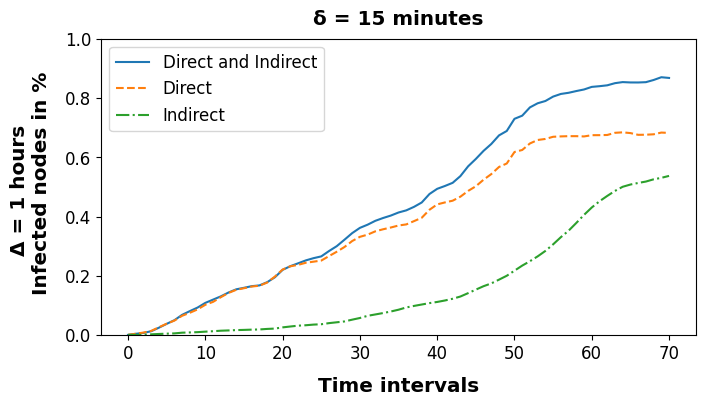

In [18]:
clf()
figure(figsize=(7,4))

for exp in get!(simulation_data, "baseline", Array{Float64, 1}())
    ylim(bottom=0.0)
    
    plot(
        exp.second.infected_distribution, 
        linestyle=linestyles[linestyle], 
        marker=markers[marker], 
        markevery=10, 
        markersize=6.5
    )

    xlabel("Time intervals", fontweight="semibold", labelpad=10, fontsize="x-large")
    ylabel("Δ = $(exp.second.Δ) hours \n Infected nodes in %", fontweight="semibold", fontsize="x-large", labelpad=10)
    title("δ = $(exp.second.δ) minutes", pad=10, fontweight="semibold", fontsize="x-large")

    tick_params(labelsize="large")

    push!(labels, exp.first)

    linestyle = (linestyle + 1) % (length(linestyles)+1)
    marker = (marker + 1) % (length(markers)+1)

    if linestyle == 0
        linestyle = 1
    end
    if marker == 0
        marker = 1
    end
end

legend(labels, fontsize="large", ncol=1)
plt.tight_layout(.5)